In [5]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


np.random.seed(0) 

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report
from sklearn.metrics import classification_report

import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Conv1D, MaxPool1D, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop

from mlxtend.plotting import plot_confusion_matrix

In [7]:
def load_images_from_folder(folder_path, label, img_size):
    
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img_resized = cv2.resize(img, (img_size, img_size))
            images.append(img_resized)
        except Exception as e:
            print(e)
    return  np.array(images)

In [4]:
img_size = 150
#"C:\Users\User\Desktop\Project ML\chest_xray\train\NORMAL"
test_normal = load_images_from_folder('C:/Users/User/Desktop/Project ML/chest_xray/test/NORMAL', 0, img_size)
test_pneumonia = load_images_from_folder('C:/Users/User/Desktop/Project ML/chest_xray/test/PNEUMONIA', 0, img_size)
train_normal = load_images_from_folder('C:/Users/User/Desktop/Project ML/chest_xray/train/NORMAL', 0, img_size)
train_pneumonia = load_images_from_folder('C:/Users/User/Desktop/Project ML/chest_xray/train/PNEUMONIA', 0, img_size)
val_normal = load_images_from_folder('C:/Users/User/Desktop/Project ML/chest_xray/val/NORMAL', 0, img_size)
val_pneumonia = load_images_from_folder('C:/Users/User/Desktop/Project ML/chest_xray/val/PNEUMONIA', 0, img_size)

In [3]:
def change_shape(array, label):
    
    array = array.reshape(array.shape[0], -1)
    new_column = np.full((array.shape[0], 1), label)
    array = np.append(array, new_column, axis=1)
    return array

def create_x_y_from_total(array):
    
    X = array[:,:-1].reshape(array.shape[0],150,150,1)
    y = array[:,-1]
    return X/255, y
    

def create_x_y(pneumonia, normal):
    
    pneumonia = change_shape(pneumonia, 1)
    normal = change_shape(normal, 0)
    total = np.concatenate((pneumonia, normal), axis=0)
    print(total.shape)
    np.random.shuffle(total)
    
    X, y = create_x_y_from_total(total)
    return (X, y)


In [6]:
X_train, y_train = create_x_y(train_pneumonia, train_normal)
X_test, y_test = create_x_y(test_pneumonia, test_normal)
X_val, y_val = create_x_y(val_pneumonia, val_normal)



(1566, 22501)
(624, 22501)
(16, 22501)


<Axes: xlabel='Condition', ylabel='count'>

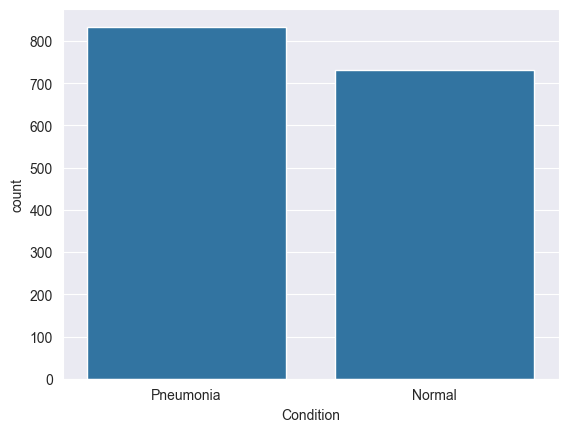

In [7]:
df = pd.DataFrame({'Condition': ['Pneumonia'] * (y_train == 1).sum() + ['Normal'] * (y_train == 0).sum()})
sns.set_style('darkgrid')
sns.countplot(data=df, x='Condition')

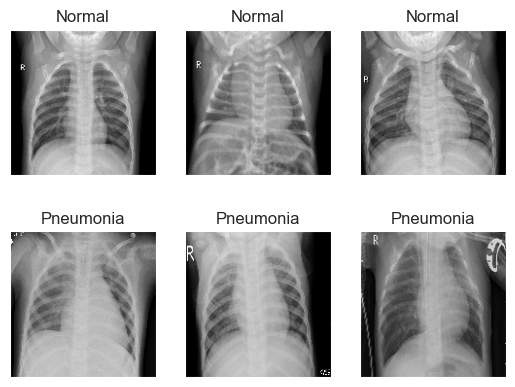

In [8]:
fig, ax = plt.subplots(2,3)
for i in range(2):
    for j in range(3):
        if i == 0:
            ax[i][j].imshow(X_train[y_train==0][j], cmap='gray')
            ax[i][j].set_title('Normal')
        else:
            ax[i][j].imshow(X_train[y_train==1][j], cmap='gray')
            ax[i][j].set_title('Pneumonia')
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

In [9]:
datagen = ImageDataGenerator(
        
        rotation_range = 30,  
        zoom_range = 0.2, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip = True,  
        )  


datagen.fit(X_train)

In [10]:
model = Sequential([
    Input((150, 150, 1)),
    Conv2D(64, (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    BatchNormalization(),
    MaxPool2D((2,2) , strides = 2 , padding = 'same'),
    Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    BatchNormalization(),
    MaxPool2D((2,2) , strides = 2 , padding = 'same'),
    Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    BatchNormalization(),
    MaxPool2D((2,2) , strides = 2 , padding = 'same'),
    Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPool2D((2,2) , strides = 2 , padding = 'same'),
    Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPool2D((2,2) , strides = 2 , padding = 'same'),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.1),
    Dense(units = 256 , activation= 'relu'),
    Dropout(0.1),
    Dense(units = 1 , activation = 'sigmoid'),
])

In [11]:
model.compile(optimizer = Nadam(0.001) , loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [14]:
history = model.fit(datagen.flow(X_train,y_train, batch_size = 32) ,epochs = 100 , 
                    validation_data = datagen.flow(X_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 49s 993ms/step - accuracy: 0.9507 - loss: 0.1412 - val_accuracy: 0.8125 - val_loss: 0.7620 - learning_rate: 1.0000e-06
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9311 - loss: 0.1874 - val_accuracy: 0.7500 - val_loss: 0.6506 - learning_rate: 1.0000e-06
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9545 - loss: 0.1476 - val_accuracy: 0.8125 - val_loss: 0.6348 - learning_rate: 1.0000e-06
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 49s 996ms/step - accuracy: 0.9445 - loss: 0.1360 - val_accuracy: 0.6875 - val_loss: 0.8755 - learning_rate: 1.0000e-06
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9562 - loss: 0.1372 - val_accuracy: 0.6875 - val_loss: 0.6622 - learning_rate: 1.0000e-06
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9575 - loss: 0.1290 - val_accuracy: 0.6250 - val_loss: 0.6826 - learning_rate: 1.0000e-06
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 48s 981ms/step - accuracy

In [15]:
print("Accuracy of the model in trainig dataset is - " , model.evaluate(X_train,y_train)[1]*100 , "%")

49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.9314 - loss: 0.1615
Accuracy of the model in trainig dataset is -  93.67815852165222 %


In [16]:
print("Loss of the model in test dataset is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model in test dataset is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.8719 - loss: 0.2695
Loss of the model in test dataset is -  0.25931695103645325
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.8719 - loss: 0.2695
Accuracy of the model in test dataset is -  88.62179517745972 %


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step


<Axes: >

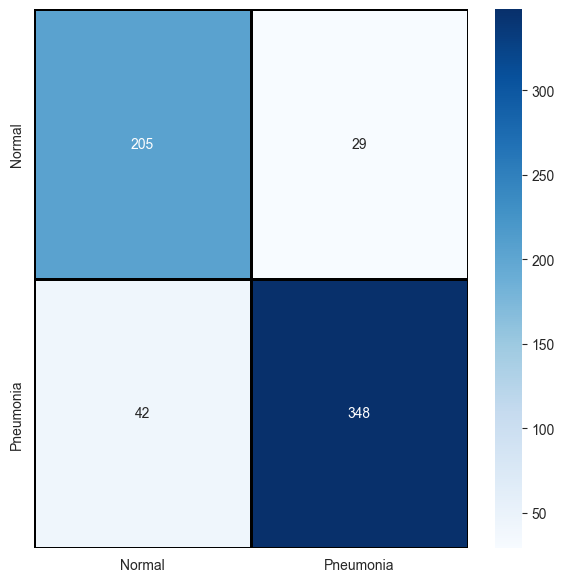

In [17]:
predictions = model.predict(X_test) >= 0.5
cm = confusion_matrix(y_test,predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (7,7))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ['Normal', 'Pneumonia'],yticklabels = ['Normal', 'Pneumonia'])

In [18]:
tp = cm.iloc[1,1]
tn = cm.iloc[0,0]
fn = cm.iloc[0,1]
fp = cm.iloc[1,0]

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = 2*(precision * recall) / (precision + recall)

print(f"Recall of the model is {round(recall, 2)}")
print(f"Precision of the model is {round(precision, 2)}")
print(f"F1 score of the model is f{round(f1_score, 2)}")

Recall of the model is 0.92
Precision of the model is 0.89
F1 score of the model is f0.91


In [19]:
model.save('cnn2.h5')

In [1]:
import os

import tensorflow as tf
from tensorflow import keras

new_model = tf.keras.models.load_model('cnn2.h5')

# Check its architecture
new_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     6,554,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 7,263,108 (27.71 MB)

 Trainable params: 7,261,953 (27.70 MB)

 Non-trainable params: 1,152 (4.50 KB)

 Optimizer params: 3 (16.00 B)

In [31]:
img_size=150

normal = load_images_from_folder('C:/Users/User/Desktop/Project ML/chest_xray/test/test111', 0, img_size)

pneumonia = load_images_from_folder('C:/Users/User/Desktop/Project ML/chest_xray/test/test222', 0, img_size)


In [32]:
X_test, y_test = create_x_y(pneumonia,normal)
print("Loss of the model in test dataset is - " , new_model.evaluate(X_test,y_test)[0])
print("Accuracy of the model in test dataset is - " , new_model.evaluate(X_test,y_test)[1]*100 , "%")

(4, 22501)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7500 - loss: 0.4303
Loss of the model in test dataset is -  0.43031179904937744
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7500 - loss: 0.4303
Accuracy of the model in test dataset is -  75.0 %


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Recall of the model is 1.0
Precision of the model is 0.5
F1 score of the model is f0.67


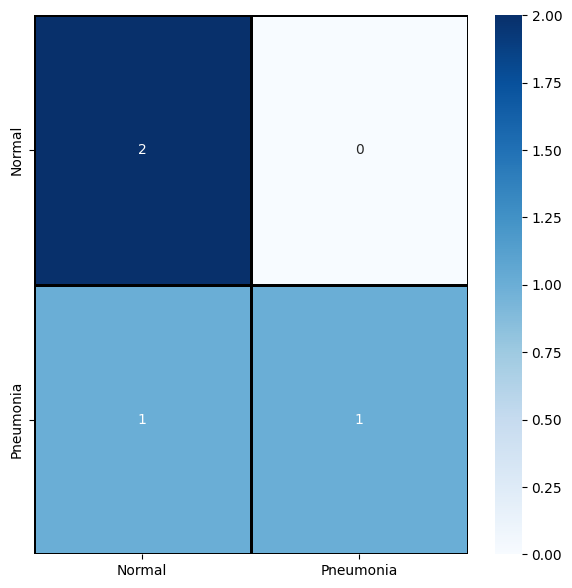

In [34]:
predictions = new_model.predict(X_test) >= 0.5
cm = confusion_matrix(y_test,predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (7,7))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ['Normal', 'Pneumonia'],yticklabels = ['Normal', 'Pneumonia'])


tp = cm.iloc[1,1]
tn = cm.iloc[0,0]
fn = cm.iloc[0,1]
fp = cm.iloc[1,0]

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = 2*(precision * recall) / (precision + recall)

print(f"Recall of the model is {round(recall, 2)}")
print(f"Precision of the model is {round(precision, 2)}")
print(f"F1 score of the model is f{round(f1_score, 2)}")